In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import zipfile

drive.mount('/content/drive')

# Build the complete path to the folder desiderated
main_folder_path = '/content/drive/MyDrive/video_recognition_proj/data/CAMUS_public'


Mounted at /content/drive


In [ ]:
!pip install opencv-python
import cv2
import nibabel as nib
import configparser
import pandas as pd
from google.colab.patches import cv2_imshow

In [ ]:
import os
import pandas as pd
import cv2
import nibabel as nib

# Define the root folder containing all the subfolders with image files
root_folder = '/content/drive/MyDrive/video_recognition_proj/data/CAMUS_public/database_nifti'

# Initialize a list to store file details
file_details_list = []

file_pattern1 = '.cfg'
file_pattern2 = '_gt.cfg'

# Iterate through subfolders in the root folder
for folder in os.listdir(root_folder):
    folder_path = os.path.join(root_folder, folder)
    print(folder_path)

    # Check if the item in the root folder is a directory (subfolder)
    if os.path.isdir(folder_path):
        # Initialize a list to store file details for this folder
        folder_file_details = []

        # List files in the subfolder
        file_list = os.listdir(folder_path)

        for file in file_list:
            file_path = os.path.join(folder_path, file)

            if file_path.endswith('.nii.gz'):
                try:
                    nii_file = nib.load(file_path)

                    # Check if the image data is empty
                    if nii_file is not None and nii_file.get_fdata().any():
                        nii_data = nii_file.get_fdata()

                        channels_to_combine = [0, 1, 2]
                        if len(nii_data.shape) == 2:
                            image_cv2 = (nii_data * 255).astype('uint8')
                        else:
                            channel_to_display = 0
                            image_cv2 = (nii_data[:, :, channel_to_display] * 255).astype('uint8')

                        # Resize the image to 256x256
                        resized_image = cv2.resize(image_cv2, (256, 256))

                        # Create a dictionary with file details
                        file_details = {
                            "File Name": file,  # Add the file name to the dictionary
                            "Image Data": resized_image,
                            "Image Shape": resized_image.shape
                        }

                        folder_file_details.append(file_details)
                except nib.filebasedimages.ImageFileError as e:
                    print(f"ImageFileError: {e}. Skipping this file.")

        # Create a Pandas DataFrame from the list of file details for this folder
        df_folder = pd.DataFrame(folder_file_details)

        # Filter rows containing '4CH' in the file name for this folder
        df_4ch = df_folder[df_folder['File Name'].str.contains('4CH')]

        # Append the filtered DataFrame to the list of file details
        file_details_list.append(df_4ch)

# Concatenate all the DataFrames for different folders into a single DataFrame
final_df = pd.concat(file_details_list, ignore_index=True)

# Now final_df contains all the files with '4CH' in their names from all the folders
print(final_df)


                                    File Name  \
0                   patient0001_4CH_ES.nii.gz   
1     patient0001_4CH_half_sequence_gt.nii.gz   
2                patient0001_4CH_ES_gt.nii.gz   
3        patient0001_4CH_half_sequence.nii.gz   
4                patient0001_4CH_ED_gt.nii.gz   
...                                       ...   
2994             patient0500_4CH_ED_gt.nii.gz   
2995                patient0500_4CH_ES.nii.gz   
2996             patient0500_4CH_ES_gt.nii.gz   
2997     patient0500_4CH_half_sequence.nii.gz   
2998  patient0500_4CH_half_sequence_gt.nii.gz   

                                             Image Data Image Shape  
0     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  (256, 256)  
1     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  (256, 256)  
2     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  (256, 256)  
3     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  (256, 256)  
4     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  (256

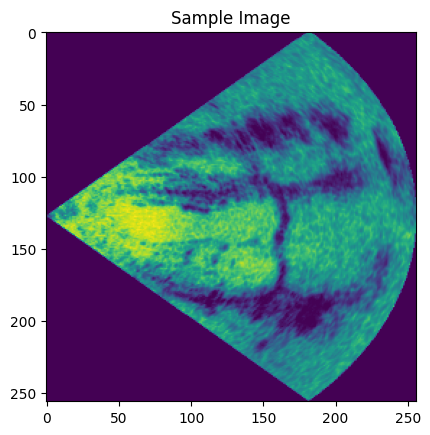

patient0001_4CH_half_sequence_gt.nii.gz


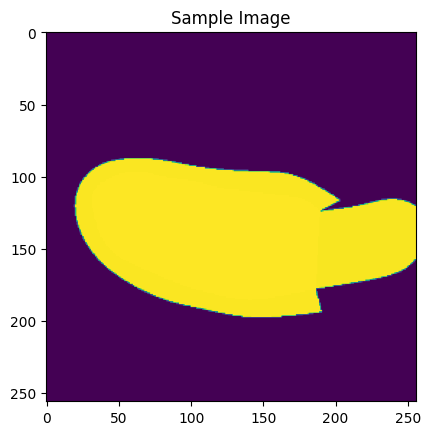

patient0001_4CH_ES_gt.nii.gz


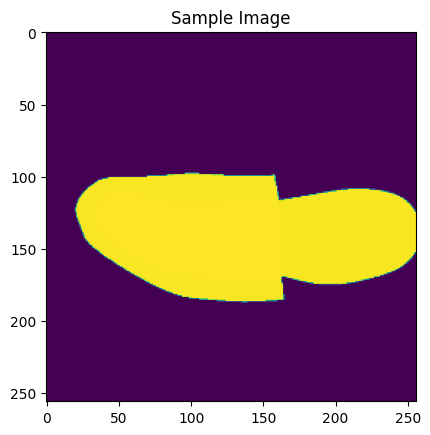

patient0001_4CH_half_sequence.nii.gz


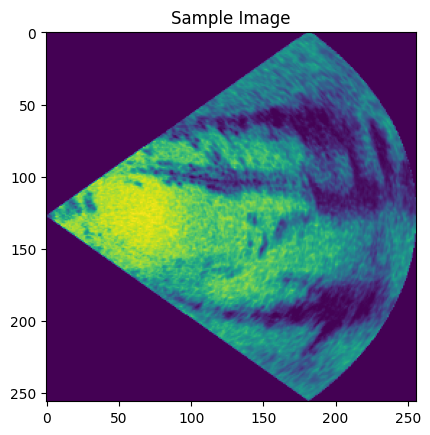

patient0001_4CH_ED_gt.nii.gz


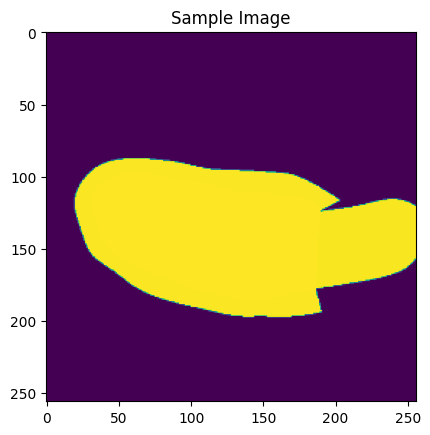

patient0001_4CH_ED.nii.gz


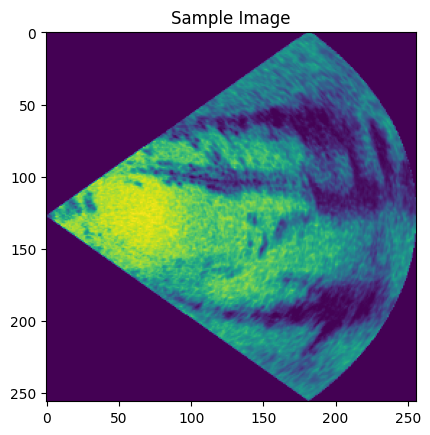

In [ ]:
print(final_df)

import matplotlib.pyplot as plt

# Display the first image in the DataFrame
for i in range(0,6):
  print(final_df['File Name'][i])
  image_to_display = final_df['Image Data'][i]  # Access the first image (change the index as needed)
  plt.imshow(image_to_display)
  plt.title('Sample Image')
  plt.show()

#patient_4CH_ES.nii.gz is a real image
#patient_4CH_half_sequence_gt is mask
#patient_4CH_ES_gt.nii.gz   mask
#patient_4CH_half_sequence.nii.gz   image
#patient_4CH_ED_gt.nii.gz   mask
#patient_4CH_ED.nii.gz image




In [ ]:
# Initialize a list to store the new data
new_data = []

def is_gt_image(image_data):
    # Modify this function to identify GT images based on your criteria
    # In this example, GT images are identified if their data contains '_gt' in the name
    return '_gt' in image_data['File Name']

# Iterate through the rows of the 'final_df'
for index, row in final_df.iterrows():
    if is_gt_image(row):
        # This row represents a GT image, and we need to associate it with the corresponding image
        # Derive the image filename by removing the '_gt' suffix
        image_filename = row['File Name'].replace('_gt', '')

        # Find the row in 'final_df' that matches the image filename
        image_row = final_df[final_df['File Name'] == image_filename]

        if not image_row.empty:
            # Create a dictionary with the image and GT information
            data_dict = {
                'Image Filename': image_filename,
                'GT Filename': row['File Name'],
                'Image Data': image_row.iloc[0]['Image Data'],
                'GT Data': row['Image Data']
            }

            new_data.append(data_dict)

# Create a new DataFrame from the list of dictionaries
new_df = pd.DataFrame(new_data)

# Print the new DataFrame
print(new_df)


                            Image Filename  \
0     patient0001_4CH_half_sequence.nii.gz   
1                patient0001_4CH_ES.nii.gz   
2                patient0001_4CH_ED.nii.gz   
3                patient0002_4CH_ED.nii.gz   
4     patient0002_4CH_half_sequence.nii.gz   
...                                    ...   
1494             patient0499_4CH_ES.nii.gz   
1495  patient0499_4CH_half_sequence.nii.gz   
1496             patient0500_4CH_ED.nii.gz   
1497             patient0500_4CH_ES.nii.gz   
1498  patient0500_4CH_half_sequence.nii.gz   

                                  GT Filename  \
0     patient0001_4CH_half_sequence_gt.nii.gz   
1                patient0001_4CH_ES_gt.nii.gz   
2                patient0001_4CH_ED_gt.nii.gz   
3                patient0002_4CH_ED_gt.nii.gz   
4     patient0002_4CH_half_sequence_gt.nii.gz   
...                                       ...   
1494             patient0499_4CH_ES_gt.nii.gz   
1495  patient0499_4CH_half_sequence_gt.nii.gz   
1496  

In [ ]:
from sklearn.model_selection import train_test_split

# Selecting only 'Image Data' and 'GT Data' columns
data = new_df[['Image Data', 'GT Data']]

# Splitting the data into X (independent variables) and Y (dependent variables)
X = data['Image Data']
Y = data['GT Data']

# Split X and Y into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Display the shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

# Print the first few rows of the train and test sets
print("X_train:")
print(X_train.head())

print("\nY_train:")
print(Y_train.head())

print("\nX_test:")
print(X_test.head())

print("\nY_test:")
print(Y_test.head())

print(X_train[0].shape)


X_train shape: (1199,)
X_test shape: (300,)
Y_train shape: (1199,)
Y_test shape: (300,)
X_train:
382     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
538     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1492    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1112    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
324     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: Image Data, dtype: object

Y_train:
382     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
538     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1492    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1112    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
324     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: GT Data, dtype: object

X_test:
1116    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1395    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
422     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
413     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
451     [[0

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

# Define the U-Net model for image segmentation
def unet(input_size=(256, 256, 1)):  # Adjusted input size to (256, 256, 1) for single-channel images
    inputs = Input(input_size)

    # Contracting path (Encoder)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottom (Bottleneck)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)

    # Expansive path (Decoder)
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up4)
    merge4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up5)
    merge5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)  # Single-channel output for segmentation masks

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create the U-Net model
model = unet(input_size=(256, 256, 1))  # Pass the input size as (256, 256, 1) for single-channel images

# Compile the model with appropriate loss and metrics for your segmentation task
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
import numpy as np

# Convert Pandas Series to Numpy arrays
X_train = np.array(X_train.tolist())
Y_train = np.array(Y_train.tolist())
X_test = np.array(X_test.tolist())
Y_test = np.array(Y_test.tolist())

# Reshape the arrays to (256, 256, 1)
X_train = X_train.reshape(-1, 256, 256, 1)
Y_train = Y_train.reshape(-1, 256, 256, 1)
X_test = X_test.reshape(-1, 256, 256, 1)
Y_test = Y_test.reshape(-1, 256, 256, 1)

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


(1199, 256, 256, 1)
(1199, 256, 256, 1)
(300, 256, 256, 1)
(300, 256, 256, 1)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class YourSegmentationDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Convert images and masks to torch tensors
        image = torch.tensor(self.images[idx], dtype=torch.float)
        mask = torch.tensor(self.masks[idx], dtype=torch.float)
        return image, mask

# Initialize your segmentation dataset
train_dataset = YourSegmentationDataset(X_train, Y_train)
test_dataset = YourSegmentationDataset(X_test, Y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Load the pre-trained DeepLabV3 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)

# Adjust the last layer to match the number of channels in your segmentation masks
num_classes = 1  # Assuming a single channel for the mask
model.classifier = nn.Conv2d(256, num_classes, kernel_size=1)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()  # Use Binary Cross Entropy for a single channel mask

# Training the model
num_epochs = 10  # Set the number of epochs for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item()}")

# Save the model after training (optional)
torch.save(model.state_dict(), 'fine_tuned_deeplabv3.pth')
